In [1]:
# 1. 데이터 불러오기
# 패키지 로드
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 구글 드라이브에서 데이터 로드(api로 데이터를 다운받은 뒤 정제하여 파일로 만들어 구글드라이브에 저장하였다)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file_name = '/content/drive/MyDrive/n23/rankdata_220215_220314.csv'

df = pd.read_csv(file_name, encoding='cp949')

In [3]:
# 나의 데이터는 
# 'mapName', 'character', 'kill', 'death', 'assist', 
# 'partyCnt', 'result', 'playTime', 'spendCoin', 'posBuff', 'possition'
# 로 이루어져 있으며,
# 각각은 다음을 의미한다

# map - 맵 정보. map 중에서도 name을 뽑아내야 한다.
# 형태: 'map': {'mapId': '102', 'name': '메트로폴리스'}


# ---------이 이하에 있는건 'playInfo' 안에 들어있음-----------------
# characterName: 플레이 한 캐릭터
# 형태: 'characterName': '에밀리'

# KDA를 계산해서 넣으면 좋을 것 같음
# 이를 위해 뽑아내야 할 데이터: 킬수, 데스수, 어시스트수
# killCount: 킬 수
# 형태: 'killCount': 1
# deathCount: 데스 수
# 형태: 'deathCount': 7
# assistCount: 어시스트 수
# 형태: 'assistCount': 6

# 파티원의 수와 파티여부를 만드는것도 좋을 것 같음
# 만약 partyUserCount가 0 이면 N, 1 이상이면 Y를 표시하도록 하자
# 이것도 추후 행으로 추가하도록 하고 일단 파티원수 데이터를 뽑아내기로 함
# partyUserCount: 파티원수
# 형태: 'partyUserCount': 2

# result: 승리여부 <- 이게 우리의 타겟변수가 될 예정
# 형태: 'result': 'lose' / 'result': 'win'

# playTime: 플레이시간
# 형태: 'playTime': 1094

# spendCoin: 코인소모량
# 형태: 'spendCoin': 13725

# ---------이 이하에 있는건 'position' 안에 들어있음-----------------
# 포지션 버프는 여러개 있지만
# 어떻게 3개를 조합하는게 승률에 영향을 주는지 알아보려 함
# 따라서, position안의 attribute에 들어있는 포지션버프이름인 name을 뽑아
# 하나의 string으로 만들어 컬럼으로 저장하고싶음
# 예를 들어, '전장의 열기-할인 판매-태세전환' 이런식으로
# level이 1인것의 name을 찾아서 저장해두고 2인걸 찾아서 저장해두고 3인걸 찾아서 저장해둔다음에
# 이런형태로 합쳐서 저장

# naem: 포지션명
# 형태: 'name': '원거리딜러'


df

,mapName,character,kill,death,assist,partyCnt,result,playTime,spendCoin,posBuff,possition
0,브리스톨,트리비아,8,4,15,0,win,873,17765,충동 구매_할인 판매_전장의 열기,원거리딜러
1,그랑플람 아시아 지부,트리비아,13,2,12,0,lose,1212,21475,전투 태세_할인 판매_불굴의 의지,탱커
2,리버포드,트리비아,8,6,12,0,lose,1394,21675,충동 구매_할인 판매_전장의 열기,원거리딜러
3,그랑플람 아시아 지부,트리비아,8,4,10,0,win,753,17015,충동 구매_할인 판매_전장의 열기,원거리딜러
4,메트로폴리스,리사,0,3,28,2,lose,991,11700,근육 손상_치유 증폭기_활성화 지원,서포터
...,...,...,...,...,...,...,...,...,...,...,...
68370,그랑플람 아시아 지부,휴톤,5,11,0,0,lose,1147,14400,불굴의 의지_재생의 숨결_최후의 저항,탱커
68371,리버포드,케니스,4,5,7,0,win,1012,17460,급소 가격_할인 판매_거인 사냥꾼,근거리딜러
68372,메트로폴리스,헤나투,5,10,4,0,lose,1194,15920,태세전환_할인 판매_전장의 열기,원거리딜러
68373,스프링필드,윌라드,2,4,9,0,win,865,14550,태세전환_할인 판매_전장의 열기,원거리딜러


In [4]:
# 2. 데이터 랭글링
# 2-1. 추가 컬럼 만들어주기
# 나는 여기서 kda점수((kill+assist)÷death)를 계산한 컬럼과,
# 파티유무(파티원수(partyCnt)가 0이면 N, 그보다 많으면 Y)를 추가해주려고 한다

# 그 전에 먼저 데이터의 타입 확인
df.dtypes

mapName      object
character    object
kill          int64
death         int64
assist        int64
partyCnt      int64
result       object
playTime      int64
spendCoin     int64
posBuff      object
possition    object
dtype: object

In [5]:
# null값 여부 확인
df.isna().sum()

mapName      0
character    0
kill         0
death        0
assist       0
partyCnt     0
result       0
playTime     0
spendCoin    0
posBuff      0
possition    0
dtype: int64

In [6]:
# kda 점수 계산
# 그런데 death수가 0이면
# k+a 점수가 kda값이 된다
# 그리고 소수점 자리수를 2자리까지 제한해주자

df['kda'] = ""

for i in range(0, len(df)):
  if df['death'][i] == 0:
    df['kda'][i] = df['kill'][i] + df['assist'][i]
  else:
    df['kda'][i] = round((df['kill'][i] + df['assist'][i]) / df['death'][i], 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# 파티유무 기입

df['isParty'] = ""

for i in range(0, len(df)):
  if df['partyCnt'][i] == 0:
    df['isParty'][i] = "N"
  else:
    df['isParty'][i] = "Y"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [67]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,063 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and d

In [9]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

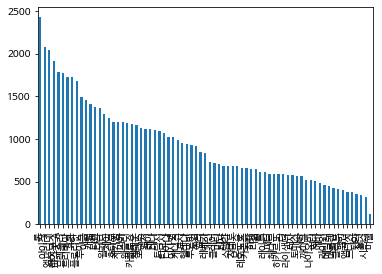

In [12]:
# 2-2. 간단한 EDA
# 1) 가장 많이 사용되는 캐릭터를 구해보자

CountStatus = pd.value_counts(df['character'].values, sort=True)
CountStatus.plot.bar()

# 유난히 높은 캐릭터가 하나 있음

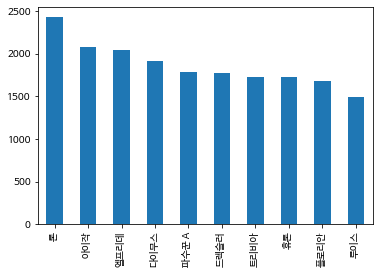

In [13]:
# 이게 누군지 알기위해
# 상위 10개만 추출
CountStatus = pd.value_counts(df['character'].values, sort=True).head(n=10)
CountStatus.plot.bar()

# 개인적인 추측으로 론이라는 캐릭터가 픽률이 높은 이유는
# 1. 원딜/탱커 모두로 사용된다
# 2. 최근에 밸런스 패치로 성능이 좋아졌다
# 3. 꾸준히 액토(액션 토너먼트. 롤로 따지면 롤챔스같은 경기)에 등장한 캐릭터일 정도로 
#    지속적으로 좋은 성능을 보여준다.

In [22]:
# 그렇다면...포지션 버프와 캐릭터를 묶으면 어떻게 될까?
# 너무 많아서 상위 10개만 뽑아봄
# grouped = df.groupby(['character', 'possition']).count()
df_ch_pos = df.groupby(['character', 'possition']).size().sort_values(ascending=False).head(n = 10)

character  possition
론          원거리딜러        2357
아이작        탱커           2043
엘프리데       원거리딜러        2032
파수꾼 A      원거리딜러        1770
드렉슬러       원거리딜러        1764
플로리안       탱커           1666
트리비아       원거리딜러        1624
휴톤         탱커           1528
다이무스       근거리딜러        1405
캐럴         원거리딜러        1371
dtype: int64

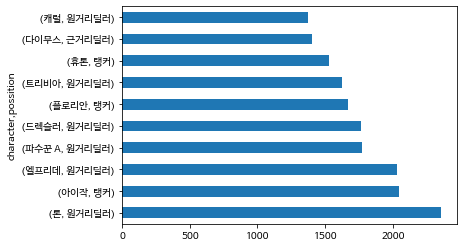

In [25]:
df_ch_pos = df.groupby(['character', 'possition']).size().sort_values(ascending=False).head(n = 10)
df_ch_pos.plot(kind='barh')

# 론을 원거리 딜러로 사용하는 유저가 가장 많음

In [27]:
# 2) 평균 킬 수, 어시스트 수, 데스 수를 구해보자

print('평균 킬 수:', df['kill'].mean(), ', 어시스트 수:', df['assist'].mean(), ', 데스 수:', df['death'].mean())


평균 킬 수: 5.20055575868373 , 어시스트 수: 9.88783912248629 , 데스 수: 4.321389396709324


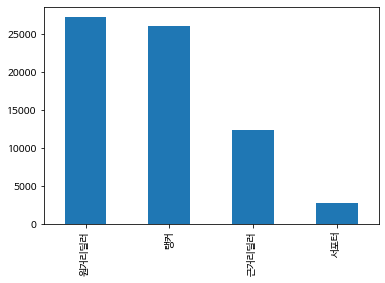

In [29]:
# 3) 가장 많이 사용하는 포지션을 구해보자

CountStatus = pd.value_counts(df['possition'].values, sort=True)
CountStatus.plot.bar()

# 원거리딜러, 탱커가 비슷할 정도로 많았고
# 3위는 근거리 딜러, 서포터는 압도적으로 적었다

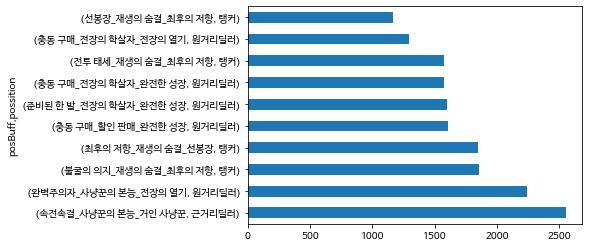

In [35]:
# 4) 가장 많이 사용하는 포지션별 TOP 5 특성 조합을 구해보자
# 번외: 전체 포지션에서 많이 사용하는 특성 조합은 무엇일까?
df_pos = df.groupby(['posBuff', 'possition']).size().sort_values(ascending=False).head(10)
df_pos.plot(kind='barh')

# 근거리 딜러의 속전속결_사냥꾼의 본능_거인 사냥꾼 특성이 가장 많았다
# 또한 근거리 딜러 경기 결과는 약 13000여 건인데, 그 중 2500여 건에서 같은 특성을 사용하고 있었다

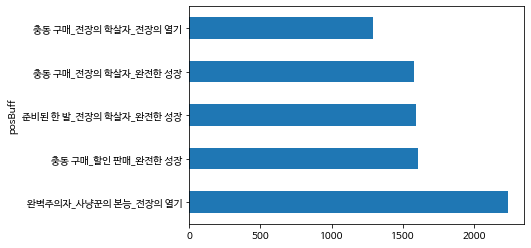

In [39]:
df_adc = df[df['possition'] == '원거리딜러']
df_tank = df[df['possition'] == '탱커']
df_punch = df[df['possition'] == '근거리딜러']
df_support = df[df['possition'] == '서포터']

# 4-1) 원거리 딜러
df_adc_gb = df_adc.groupby('posBuff').size().sort_values(ascending=False).head(5)
df_adc_gb.plot(kind='barh')

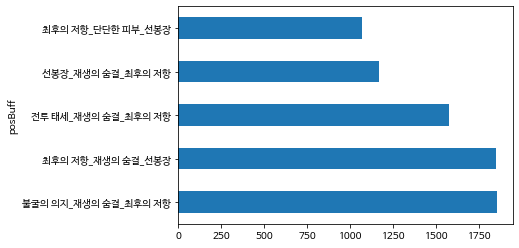

In [40]:
# 4-2) 탱커
df_tank_gb = df_tank.groupby('posBuff').size().sort_values(ascending=False).head(5)
df_tank_gb.plot(kind='barh')

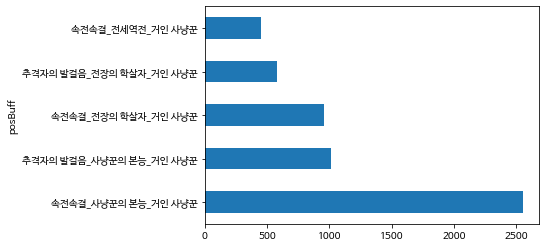

In [41]:
# 4-3) 근거리 딜러
df_punch_gb = df_punch.groupby('posBuff').size().sort_values(ascending=False).head(5)
df_punch_gb.plot(kind='barh')

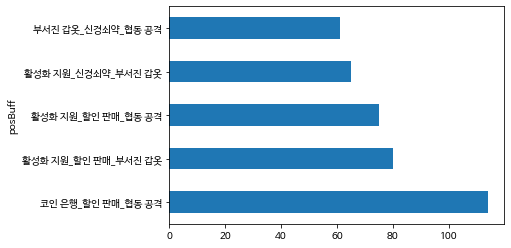

In [42]:
# 4-4) 서포터
df_spt_gb = df_support.groupby('posBuff').size().sort_values(ascending=False).head(5)
df_spt_gb.plot(kind='barh')

In [43]:
# 5) 상위 1000명은 얼마나 이길까? 총 승리 횟수외 패배 횟수를 세어 보자
pd.value_counts(df['result'].values)

win     38231
lose    30144
dtype: int64

In [9]:
# 2-3. train/validation/test 세트로 나누기

train, test = train_test_split(df, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape, test.shape

((43760, 13), (10940, 13), (13675, 13))

In [10]:
target = 'result'
features = df.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [10]:
pip install --upgrade category_encoders

     |████████████████████████████████| 86 kB 4.5 MB/s 


In [11]:
# 3. 베이스라인 모델 만들기
# 먼저, 타겟 범주가 어떤 비율을 가지고 있는지 확인해보자

df['result'].value_counts()

win     38231
lose    30144
Name: result, dtype: int64

In [12]:
# 최빈값을 기준으로 베이스라인 모델 생성
from sklearn.metrics import accuracy_score

target = 'result'

# 라벨 분리
features = df.drop(columns=[target]).columns,
y_df = df[target]

# mode(): Return the highest frequency value in a Series
major = y_df.mode()[0]
# 타겟 샘플 수 만큼 0이 담긴 리스트를 만든다
y_pred = [major] * len(y_df)

# 정확도 도출
accuracy_score = accuracy_score(y_df, y_pred)

In [13]:
accuracy_score

0.5591371115173674

In [14]:
# 4. 간단한 모델 만들기
# 랜덤 포레스트 모델을 만들어보자

# 패키지 로드
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
# 파이프라인 생성
# 간단하게 만들 것이기 때문에,
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, max_depth = 10)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.8479890310786106


In [16]:
# 좀 더 복잡한 랜덤 포레스트
# 왜 랜덤 포레스트를 사용했는지 이유를 생각해보자
# : 자체적으로 오버피팅을 예방하는 효과가 있기 때문에 사용했..으나 그렇게 크게 체감은 못했다
# 그리고 랜덤포레스트 모델의 성능이 다양한 머신러닝 모델들 중에서도 높은 편이라고 한다.
# 그래서 이번엔 좀 다른 결과를 내기 위해 RandomizedSearchCV를 통해
# 랜덤 포레스트 모델의 하이퍼파라미터를 잘 찾아보고 최적의 모델을 뽑으려고 한다

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder



from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

In [17]:
# 각 변수를 이렇게 설정한 이유에 대해 설명해보자
# :
# 현재는 AUC 스코어가 0.9267858338588689로 나옴
# 검증 정확도가 0.847989로, 생각보다 높게 나왔기 때문에 overfitting의 가능성을 고려한다
# 데이터 정규화 과정을 파이프라인에 추가해주자

scaler = MinMaxScaler()

# pipeline = make_pipeline(
#     OrdinalEncoder(),
#     SimpleImputer(),
#     RandomForestClassifier(random_state = 2)
# )


pipeline = make_pipeline(
  # 문자로 된 데이터가 있기 때문에 일단 인코더를 돌려 변환을 해준 뒤
  # 스케일링을 해보자
  OrdinalEncoder(),
  scaler,
  SimpleImputer(),
  # 난수 seed를 2로 설정
  RandomForestClassifier(random_state = 2)
)


dists = {
  # 'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
  # 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)를 50이상 500이하의 범위 내에서 랜덤하게 생성, 
  'randomforestclassifier__n_estimators': randint(50, 500),
  # 트리의 최대 깊이를 5 이상 20 이하의 범위 내에서 랜덤하게 생성
  'randomforestclassifier__max_depth': randint(5, 20),
  # 각 노드에서 분할에 사용할 특징의 최대 개수를 0이상 1이하의 실수만큼 랜덤하게 생성
  'randomforestclassifier__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
  pipeline, 
  param_distributions=dists, # 파라미터 입력
  n_iter=10, # random search 탐색 횟수
  cv=3, # cv 검증을 위한 분할 검증 횟수
  # 일반적으로 분류모델에서 사용되는 평가지표인 accuracy를 사용하였다
  scoring='accuracy', # 오차 평가방법
  verbose=1, #진행상황
  n_jobs=-1
)

clf.fit(X_train, y_train)
print("최적 하이퍼파라미터:", clf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


최적 하이퍼파라미터: {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 0.394053774056744, 'randomforestclassifier__n_estimators': 429}


In [18]:
y_test_pred = clf.predict(X_test)
print("검증 정확도: ", clf.best_score_)
# 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을수록 높은 값을 갖는
# f1 스코어로 평가
print('F1', f1_score(y_test, y_test_pred, pos_label = 'win'))

검증 정확도:  0.8418190225540848
F1 0.8650404432838673


In [19]:
# 스케일러를 도입하기 이전엔 정확도가 0.93 정도엿으나,
# 도입 후 0.87 정도로 줄어들었다
# 과적합을 약간이나마 예방하는 데 성공
print(classification_report(y_test_pred, y_test))

# Precision: TP / (TP + FP)
# 정밀도. 예측값이 얼마나 정확한가?

# Recall: TP / (TP + FN)
# 재현율. 실제 정답을 얼마나 맞췄나?

# F1 Score:  2*(Recall * Precision) / (Recall + Precision)
# Precision과 Recall의 조화평균
# 주로 분류 클래스 간의 데이터가 불균형이 심할 때 사용(높을 수록 좋음)

              precision    recall  f1-score   support

        lose       0.80      0.84      0.82      5658
         win       0.88      0.85      0.87      8017

    accuracy                           0.85     13675
   macro avg       0.84      0.84      0.84     13675
weighted avg       0.85      0.85      0.85     13675



In [39]:
pipeline.steps

[('ordinalencoder', OrdinalEncoder()),
 ('minmaxscaler', MinMaxScaler()),
 ('simpleimputer', SimpleImputer()),
 ('randomforestclassifier', RandomForestClassifier(random_state=2))]

In [61]:
clf.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['mapName', 'character', 'posBuff',
                                      'possition', 'kda', 'isParty'],
                                mapping=[{'col': 'mapName',
                                          'data_type': dtype('O'),
                                          'mapping': 메트로폴리스         1
리버포드           2
스프링필드          3
그랑플람 아시아 지부    4
브리스톨           5
NaN           -2
dtype: int64},
                                         {'col': 'character',
                                          'data_type': dtype('O'),
                                          'mapping': 리사       1
플로리안     2
로라스      3
마틴       4
윌라드      5
        ..
시드니     70
미아      71
앨리셔     72
미쉘      73
NaN     -2
Length: 74, dtype: int64},
                                         {'col...
4.00       2
4.25       3
5.67       4
32.00      5
        ... 
0.69     319
6.83     320
53.00    321
0.35     322
NaN       -2
Length: 323, dt

In [48]:
pipeline.named_steps['randomforestclassifier']

RandomForestClassifier(random_state=2)

In [49]:
clf.best_estimator_.named_steps['randomforestclassifier']

RandomForestClassifier(max_depth=11, max_features=0.5962358763532013,
                       n_estimators=116, random_state=2)

In [44]:
clf.best_estimator_.steps

[('ordinalencoder',
  OrdinalEncoder(cols=['mapName', 'character', 'posBuff', 'possition', 'kda',
                       'isParty'],
                 mapping=[{'col': 'mapName', 'data_type': dtype('O'),
                           'mapping': 메트로폴리스         1
  리버포드           2
  스프링필드          3
  그랑플람 아시아 지부    4
  브리스톨           5
  NaN           -2
  dtype: int64},
                          {'col': 'character', 'data_type': dtype('O'),
                           'mapping': 리사       1
  플로리안     2
  로라스      3
  마틴       4
  윌라드      5
          ..
  시드니     70
  미아      71
  앨리셔     72
  미쉘      73
  NaN     -2
  Length: 74, dtype: int64},
                          {'col': 'posBuff', 'data_type': dtype('O')...
  태세전환_회피 사격_전장의 학살자        1231
  충동 구매_돌격전차_최후의 저항         1232
  NaN                         -2
  Length: 1233, dtype: int64},
                          {'col': 'possition', 'data_type': dtype('O'),
                           'mapping': 원거리딜러    1
  탱커       2
  서포터      3
 

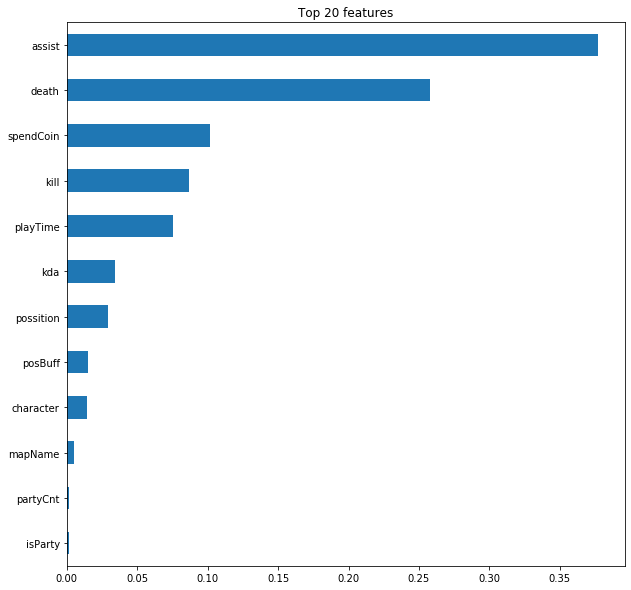

In [20]:
# 모델의 Permutation importances 알아보기
# 간단하게 아무 파라미터나 지정해 줬을 때의 모델

rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

# 특성 중요도를 표로 나타냄


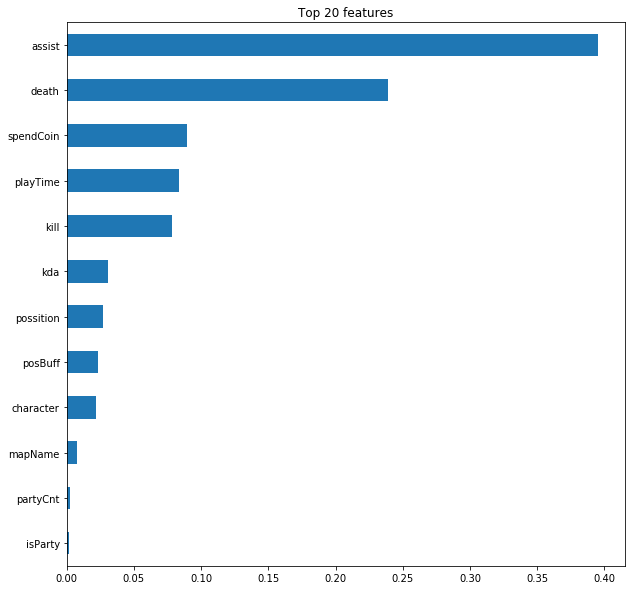

In [21]:
# 모델의 Permutation importances 알아보기
# 최적의 파라미터로 학습한 모델
rf = clf.best_estimator_.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

# 특성 중요도를 표로 나타냄
# 위보다 playTime이 중요하게 나타남

In [35]:
# 5. 모델 해석하기
# 패키지 설치
!pip install shap
!pip install PDPbox

     |████████████████████████████████| 564 kB 14.0 MB/s 
     |████████████████████████████████| 34.0 MB 127 kB/s 
     |████████████████████████████████| 13.1 MB 39.9 MB/s 
  Created wheel for PDPbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=f7d3ce3d11865f67601b60f950720a4454fa30410c6a3c9892fdd6971986eb23
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built PDPbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [22]:
# 패키지 로드
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


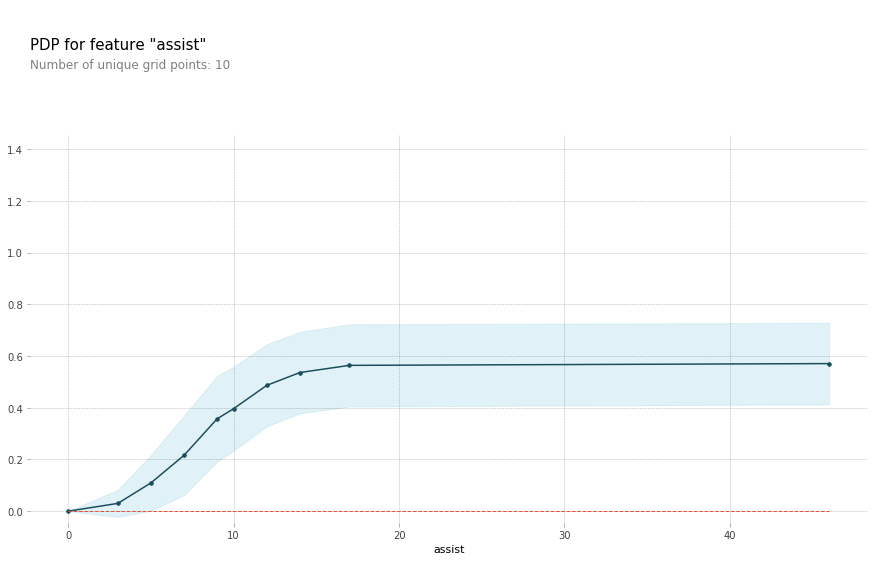

In [23]:
# 5-1. 위에서 가장 중요한 특성으로 나왔던 assist에 대해서 
# PDP를 그려보자

feature = 'assist'

isolated = pdp_isolate(
    model=clf.best_estimator_, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [ ]:
# assist 수가 많을 수록 
# 타겟변수의 positive value(승리)에 대한 확률이 올라감
# 그렇지만, assist수가 20 이상일때부터는
# 동일한 확률로 분포함

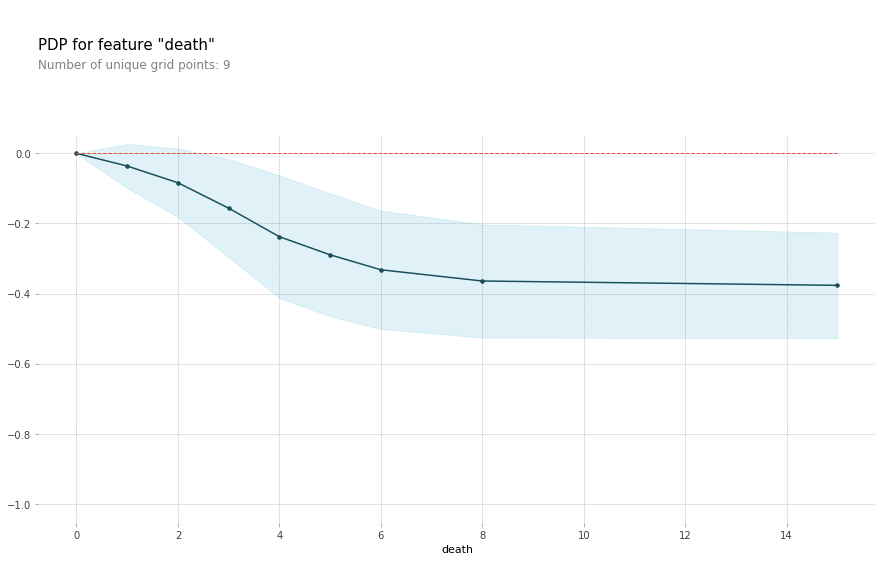

In [24]:
# 5-2. 위에서 두번째로 중요한 특성으로 나왔던 death에 대해서 
# PDP를 그려보자

feature = 'death'

isolated = pdp_isolate(
    model=clf.best_estimator_, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [ ]:
# 데스 수가 많을 수록
# 타겟변수의 positive value(승리)에 대한 확률이 감소함

In [25]:
# 5-3. assist, death 특성의 상호작용을 알아보자

features = ['assist', 'death']

interaction = pdp_interact(
    model=clf.best_estimator_, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


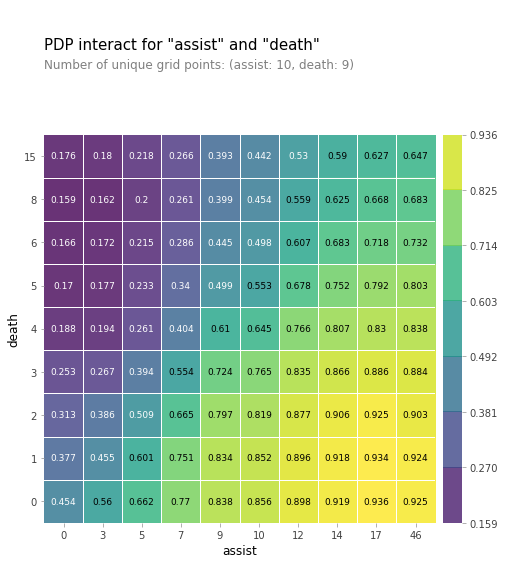

In [26]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [ ]:
# 어시스트수가 많을수록, 데스수가 적을수록
# 승리할 확률이 높음을 알 수 있음

In [59]:
X_test.iloc[[1]]

,mapName,character,kill,death,assist,partyCnt,playTime,spendCoin,posBuff,possition,kda,isParty
6447,메트로폴리스,멜빈,12,1,12,0,1071,21275,준비된 한 발_전장의 학살자_전장의 열기,원거리딜러,24.0,N


In [75]:
pipe

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['mapName', 'character', 'posBuff',
                                      'possition', 'kda', 'isParty'],
                                mapping=[{'col': 'mapName',
                                          'data_type': dtype('O'),
                                          'mapping': 메트로폴리스         1
리버포드           2
스프링필드          3
그랑플람 아시아 지부    4
브리스톨           5
NaN           -2
dtype: int64},
                                         {'col': 'character',
                                          'data_type': dtype('O'),
                                          'mapping': 리사       1
플로리안     2
로라스      3
마틴       4
윌라드      5
        ..
시드니     70
미아      71
앨리셔     72
미쉘      73
NaN     -2
Length: 74, dtype: int64},
                                         {'col...
dtype: int64},
                                         {'col': 'kda', 'data_type': dtype('O'),
                                          'mappin

In [74]:
clf.best_estimator_.named

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['mapName', 'character', 'posBuff',
                                      'possition', 'kda', 'isParty'],
                                mapping=[{'col': 'mapName',
                                          'data_type': dtype('O'),
                                          'mapping': 메트로폴리스         1
리버포드           2
스프링필드          3
그랑플람 아시아 지부    4
브리스톨           5
NaN           -2
dtype: int64},
                                         {'col': 'character',
                                          'data_type': dtype('O'),
                                          'mapping': 리사       1
플로리안     2
로라스      3
마틴       4
윌라드      5
        ..
시드니     70
미아      71
앨리셔     72
미쉘      73
NaN     -2
Length: 74, dtype: int64},
                                         {'col...
4.00       2
4.25       3
5.67       4
32.00      5
        ... 
0.69     319
6.83     320
53.00    321
0.35     322
NaN       -2
Length: 323, dt

In [77]:
model = clf.best_estimator_

In [78]:
model

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['mapName', 'character', 'posBuff',
                                      'possition', 'kda', 'isParty'],
                                mapping=[{'col': 'mapName',
                                          'data_type': dtype('O'),
                                          'mapping': 메트로폴리스         1
리버포드           2
스프링필드          3
그랑플람 아시아 지부    4
브리스톨           5
NaN           -2
dtype: int64},
                                         {'col': 'character',
                                          'data_type': dtype('O'),
                                          'mapping': 리사       1
플로리안     2
로라스      3
마틴       4
윌라드      5
        ..
시드니     70
미아      71
앨리셔     72
미쉘      73
NaN     -2
Length: 74, dtype: int64},
                                         {'col...
4.00       2
4.25       3
5.67       4
32.00      5
        ... 
0.69     319
6.83     320
53.00    321
0.35     322
NaN       -2
Length: 323, dt

In [79]:
clf.best_estimator_.named_steps['randomforestclassifier']

RandomForestClassifier(max_depth=11, max_features=0.5962358763532013,
                       n_estimators=116, random_state=2)

In [80]:
clf.best_estimator_[:3]

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['mapName', 'character', 'posBuff',
                                      'possition', 'kda', 'isParty'],
                                mapping=[{'col': 'mapName',
                                          'data_type': dtype('O'),
                                          'mapping': 메트로폴리스         1
리버포드           2
스프링필드          3
그랑플람 아시아 지부    4
브리스톨           5
NaN           -2
dtype: int64},
                                         {'col': 'character',
                                          'data_type': dtype('O'),
                                          'mapping': 리사       1
플로리안     2
로라스      3
마틴       4
윌라드      5
        ..
시드니     70
미아      71
앨리셔     72
미쉘      73
NaN     -2
Length: 74, dtype: int64},
                                         {'col...
                                         {'col': 'possition',
                                          'data_type': dtype('O'),
                

In [37]:
# 5-4. SHAP로 모델 해석하기
model = clf.best_estimator_.named_steps['randomforestclassifier']
preprocessing = clf.best_estimator_.named_steps['ordinalencoder']
explainer = shap.TreeExplainer(model)
# 테스트세트의 한 행을 가져옴
row = X_test.iloc[[1]]
# SHAP은 pipeline은 지원하지 않기 때문에
# 전처리 과정(스케일링, 인코딩 등)을 한번 거쳐두려고 함
data_transformation = preprocessing.transform(row)

shap_values = explainer(data_transformation)


In [38]:
data_transformation

,mapName,character,kill,death,assist,partyCnt,playTime,spendCoin,posBuff,possition,kda,isParty
6447,1,35,12,1,12,0,1071,21275,10,1,74,1


In [40]:
shap_values

.values =
array([[[ 0.00362738, -0.00362738],
        [ 0.01928454, -0.01928454],
        [-0.06136933,  0.06136933],
        [ 0.11453824, -0.11453824],
        [-0.14058308,  0.14058308],
        [ 0.00037166, -0.00037166],
        [ 0.06731252, -0.06731252],
        [-0.03720196,  0.03720196],
        [ 0.00116932, -0.00116932],
        [-0.0064839 ,  0.0064839 ],
        [-0.00053379,  0.00053379],
        [-0.00324365,  0.00324365]]])

.base_values =
array([[0.44170699, 0.55829301]])

.data =
array([[    1,    35,    12,     1,    12,     0,  1071, 21275,    10,
            1,    74,     1]])

In [39]:
# shap 그래프 그리기
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

Exception: ignored

In [62]:
# 5-4. SHAP로 모델 해석하기
model = clf.best_estimator_.named_steps['randomforestclassifier']
preprocessing = clf.best_estimator_[:3]
explainer = shap.TreeExplainer(model)
# 테스트세트의 한 행을 가져옴
row = X_test.iloc[[1]]
# SHAP은 pipeline은 지원하지 않기 때문에
# 전처리 과정(스케일링, 인코딩 등)을 한번 거쳐두려고 함
data_transformation = preprocessing.transform(row)

shap_values = explainer.shap_values(data_transformation)


In [53]:
shap_values

[array([[ 0.00048559, -0.00346199, -0.08741177, -0.16269447, -0.11647233,
         -0.00091569,  0.02868673, -0.06025309, -0.00094345,  0.01865173,
         -0.00654108, -0.00084651]]),
 array([[-0.00048559,  0.00346199,  0.08741177,  0.16269447,  0.11647233,
          0.00091569, -0.02868673,  0.06025309,  0.00094345, -0.01865173,
          0.00654108,  0.00084651]])]

In [50]:
shap_values[0]

array([[ 0.00048559, -0.00346199, -0.08741177, -0.16269447, -0.11647233,
        -0.00091569,  0.02868673, -0.06025309, -0.00094345,  0.01865173,
        -0.00654108, -0.00084651]])

In [51]:
explainer.expected_value

array([0.44170699, 0.55829301])

In [52]:
# shap 그래프 그리기
# 왠지 모르겠는데 전처리 하고나니까 shap_values가 2개의 -, +만 바뀐 배열로 이뤄져있음...
# 그래서 shap_values[0]으로 앞에거 하나, 뒤에거 하나 이렇게 하려 함
# (이게 맞는지는 모르겠습니다???하하하하하하)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],
    features=row
)

# 빨간색이 영향도가 높고, 파란색이 영향도가 낮음
# 포지션과 플레이 시간의 영향이 큼을 보여줌
# ...그런데 무엇에 영향을 주는걸까? 알수가없다 하아아...여기까지가 내 능력의 한계인듯ㅠ

In [63]:
# shap 그래프 그리기
# 왠지 모르겠는데 전처리 하고나니까 shap_values가 2개의 -, +만 바뀐 배열로 이뤄져있음...
# 그래서 shap_values[0]으로 앞에거 하나, 뒤에거 하나 이렇게 하려 함
# (이게 맞는지는 모르겠습니다???하하하하하하)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=row
)

# 위에랑 반대로 나타남
# 빨간색이 영향도가 높고, 파란색이 영향도가 낮음
# 포지션과 플레이 시간의 영향이 작음을 보여줌
# ...그런데 무엇에 영향을 주는걸까? 알수가없다 하아아...여기까지가 내 능력의 한계인듯ㅠ
# 그런데 이게 맞는거 같습니다.................
# 아마 위에서 피처엔지니어랑 한거랑 같이 유추해보면
# 승리에 영향을 끼치는 요인 정도가 아닐까요?
# 하하하하하하하하하하하하하하하.........................(근데 똑같이 랜덤포레스트 사용하셨다는 상혁님이랑 비교해보니 이것도 아닌거같음)
# 일단 [0]이 패배, [1]이 승리로 가정하고 해석을 진행하기로 함(제일 가능성 있는 가설이기 때문에)

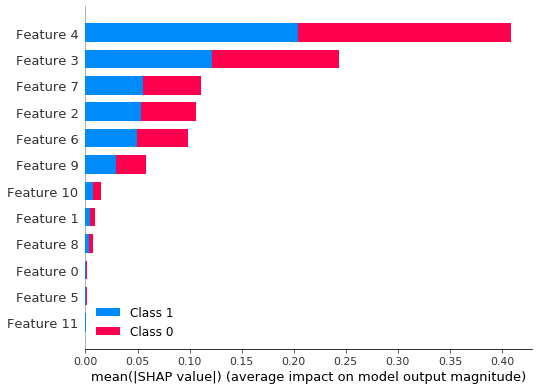

In [55]:
# 이번엔 테스트 데이터 중 300개를 꼽아 그래프를 그려보자
data_transformation = preprocessing.transform(X_test.iloc[:300])
shap_values = explainer.shap_values(data_transformation)
shap.summary_plot(shap_values, data_transformation)

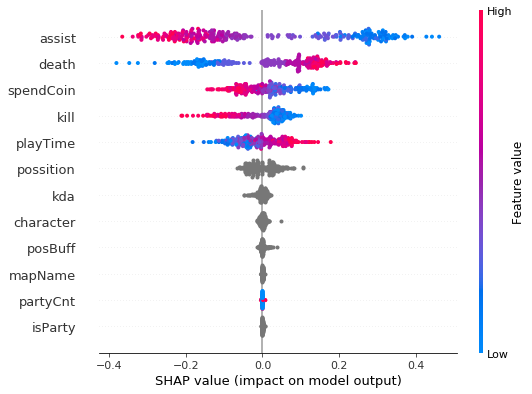

In [58]:
# 이번엔 테스트 데이터 중 300개를 꼽아 그래프를 그려보자([0])
data_transformation = preprocessing.transform(X_test.iloc[:300])
shap_values = explainer.shap_values(data_transformation)
shap.summary_plot(shap_values[0], X_test.iloc[:300])

# 모든 변수들의 shap value를 요약한 것
# 해당 변수가 빨간색을 띄면 target(price)에 대해 양의 영향력이 존재함
# 파란색을 띄면 음의 영향력이 존재하는 것

# assist: 변수의 값(어시스트 수)가 낮을수록, 패배할 경향성이 있음
# death: 변수의 값(death 수)이 높을수록, 패배할 경향성이 있음
# spendCoin(코인 소모량): 코인 소모량이 작을 수록, 패배할 경향성이 있음
# kill: 변수의 값(킬 수)이 낮을 수록, 패배할 경향성이 있음 
# playTime: 플레이 시간이 길수록, 패배할 경향성이 있음
# position ~ isParty: Feature Value에 따른 Shap Values의 상관성 파악이 모호함

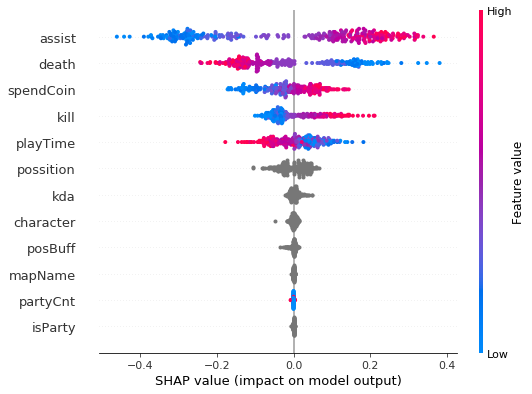

In [59]:
# 이번엔 테스트 데이터 중 300개를 꼽아 그래프를 그려보자([1])
data_transformation = preprocessing.transform(X_test.iloc[:300])
shap_values = explainer.shap_values(data_transformation)
shap.summary_plot(shap_values[1], X_test.iloc[:300])

# assist: 변수의 값(어시스트 수)가 높을수록, 승리할 경향성이 있음
# death: 변수의 값(death 수)이 낮을수록, 승리할 경향성이 있음
# spendCoin(코인 소모량): 코인 소모량이 많을수록, 승리할 경향성이 있음
# kill: 변수의 값(킬 수)이 클수록, 승리할 경향성이 있음 
# playTime: 플레이 시간이 짧을수록, 승리할 경향성이 있음
# position ~ isParty: Feature Value에 따른 Shap Values의 상관성 파악이 모호함

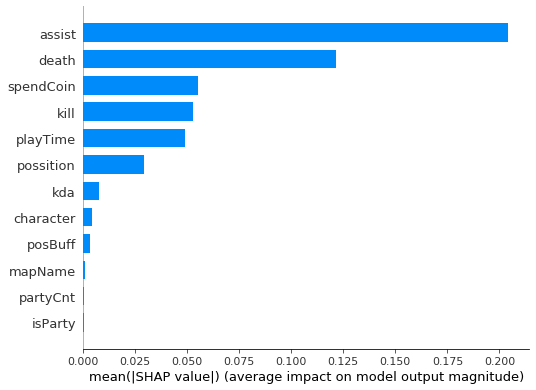

In [64]:
# 각 변수에 대한 |Shap Values|를 통해 변수 importance를 파악([0])
data_transformation = preprocessing.transform(X_test.iloc[:300])
shap_values = explainer.shap_values(data_transformation)
shap.summary_plot(shap_values[0], X_test.iloc[:300], plot_type = "bar")

# 각 변수의 shap value에 절대값을 취한 것으로, 변수의 평균적인 영향력을 보여줌
# 큰 영향력을 보일수록, target과 관계성(인과관계X)가 크다는 뜻(변수의 중요도와 비슷한 개념)


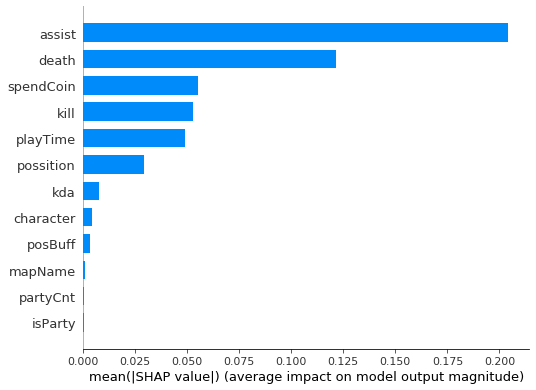

In [65]:
# 각 변수에 대한 |Shap Values|를 통해 변수 importance를 파악([1])
shap.summary_plot(shap_values[1], X_test.iloc[:300], plot_type = "bar")

In [29]:
shap_values

.values =
array([[[ 0.00048559, -0.00048559],
        [-0.00346199,  0.00346199],
        [-0.08741177,  0.08741177],
        [-0.16269447,  0.16269447],
        [-0.11647233,  0.11647233],
        [-0.00091569,  0.00091569],
        [ 0.02868673, -0.02868673],
        [-0.06025309,  0.06025309],
        [-0.00094345,  0.00094345],
        [ 0.01865173, -0.01865173],
        [-0.00654108,  0.00654108],
        [-0.00084651,  0.00084651]]])

.base_values =
array([[0.44170699, 0.55829301]])

.data =
array([[0.        , 0.47222222, 0.4       , 0.05555556, 0.21428571,
        0.        , 0.54320988, 0.77645985, 0.00731113, 0.        ,
        0.22741433, 0.        ]])

In [34]:
data_transformation

array([[0.        , 0.47222222, 0.4       , 0.05555556, 0.21428571,
        0.        , 0.54320988, 0.77645985, 0.00731113, 0.        ,
        0.22741433, 0.        ]])

In [33]:
explainer.expected_value[0]

0.4417069904501352